# ## 1. Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import json
import pickle
import warnings
import psycopg2
from sqlalchemy import create_engine
import os
warnings.filterwarnings('ignore')

In [2]:
# ML libraries
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_regression, mutual_info_regression
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import xgboost as xgb
import lightgbm as lgb
import optuna

In [3]:
# Set up display options for pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Set up plot style
sns.set(style="whitegrid")
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (12, 8)

# ## 2. Database Connection and Data Loading

In [4]:
# PostgreSQL connection parameters
DB_HOST = "localhost"  
DB_PORT = "5432"       
DB_NAME = "ward_data"  
DB_USER = "kshitizbhatnagar" 

def get_db_connection():
    """Create a connection to the PostgreSQL database"""
    try:
        connection_string = f"postgresql://{DB_USER}:@{DB_HOST}:{DB_PORT}/{DB_NAME}"
        engine = create_engine(connection_string)
        print("Successfully connected to PostgreSQL database!")
        return engine
    except Exception as e:
        print(f"Error connecting to database: {e}")
        return None

def load_data_from_postgres():
    """Load the hospital data from PostgreSQL database"""
    engine = get_db_connection()
    if engine is None:
        raise Exception("Failed to connect to database")
    
    # Query to load data from hospital_data table
    query = "SELECT * FROM hospital_data"
    
    # Load data into pandas DataFrame
    df = pd.read_sql_query(query, engine)
    
    print(f"Loaded {len(df)} records from PostgreSQL database")
    return df

In [5]:
# Load the data
df = load_data_from_postgres()

# Display basic information about the dataset
print("Dataset shape:", df.shape)
print("\nDataset columns:", df.columns.tolist())
print("\nDataset info:")
df.info()

# Check for missing values
print("\nMissing values:")
print(df.isnull().sum())

# Display summary statistics
print("\nSummary statistics:")
print(df.describe())

Successfully connected to PostgreSQL database!
Loaded 14001 records from PostgreSQL database
Dataset shape: (14001, 22)

Dataset columns: ['mrn', 'age', 'gender', 'visit_id', 'comorbidities', 'num_comorbidities', 'visit_date', 'expected_discharge_date', 'actual_discharge_date', 'actual_los', 'primary_diagnosis', 'severity_score', 'heart_rate', 'systolic_bp', 'temperature', 'oxygen_saturation', 'is_surgical', 'ward_occupancy_pct', 'laboratory_report_time', 'pharmacy_billing_time', 'insurance_claim_settlement_time', 'discharge_summary_time']

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14001 entries, 0 to 14000
Data columns (total 22 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   mrn                              14001 non-null  object        
 1   age                              14001 non-null  int64         
 2   gender                           14001 non-null  

In [6]:
# Display first few rows
print("\nFirst 5 rows:")
display(df.head())


First 5 rows:


,mrn,age,gender,visit_id,comorbidities,num_comorbidities,visit_date,expected_discharge_date,actual_discharge_date,actual_los,primary_diagnosis,severity_score,heart_rate,systolic_bp,temperature,oxygen_saturation,is_surgical,ward_occupancy_pct,laboratory_report_time,pharmacy_billing_time,insurance_claim_settlement_time,discharge_summary_time
0,000001,63,F,1,"Tuberculosis,Hypertension",2,2025-01-31 21:25:00,2025-02-08,2025-02-06 21:25:00,6,Malaria,2,84.331,117.770,38.131,99.077,Yes,75.530,27:58:41,16:14:46,85:50:43,08:51:56
1,000002,57,M,2,None,0,2024-08-01 21:59:00,2024-08-08,2024-08-07 21:59:00,6,Heart Failure,4,91.865,94.134,38.211,91.558,No,86.962,42:03:53,18:25:43,57:09:35,09:13:22
2,000002,57,M,3,None,0,2024-07-06 21:45:00,2024-07-14,2024-07-15 21:45:00,9,COPD Exacerbation,4,86.619,87.351,38.161,92.313,Yes,84.738,01:43:07,11:50:16,31:34:34,02:58:04
3,000002,57,M,4,None,0,2025-03-20 11:52:00,2025-03-26,2025-03-25 11:52:00,5,GI Bleed,5,105.125,127.344,37.964,95.007,Yes,91.405,01:04:25,23:13:38,50:08:14,11:41:59
4,000003,29,M,5,"Diabetes,Chronic Kidney Disease,Coronary Arter...",3,2025-04-03 14:48:00,2025-04-08,2025-04-09 14:48:00,6,UTI,4,101.154,114.931,37.535,95.027,No,87.405,28:24:38,01:00:56,50:56:51,10:02:38


# ## 3. Data Preprocessing Functions

In [7]:
def preprocess_data(df):
    """
    Preprocess the dataset for modeling
    
    Parameters:
    -----------
    df : pandas DataFrame
        Raw data
        
    Returns:
    --------
    df_processed : pandas DataFrame
        Processed data ready for modeling
    """
    df_processed = df.copy()
    
    # Convert date columns to datetime
    df_processed['visit_date'] = pd.to_datetime(df_processed['visit_date'])
    df_processed['actual_discharge_date'] = pd.to_datetime(df_processed['actual_discharge_date'])
    
    # Extract useful datetime features
    df_processed['visit_year'] = df_processed['visit_date'].dt.year
    df_processed['visit_month'] = df_processed['visit_date'].dt.month
    df_processed['visit_day'] = df_processed['visit_date'].dt.day
    df_processed['visit_hour'] = df_processed['visit_date'].dt.hour
    df_processed['visit_weekday'] = df_processed['visit_date'].dt.weekday
    df_processed['visit_is_weekend'] = df_processed['visit_weekday'].apply(lambda x: 1 if x >= 5 else 0)
    
    # Convert time fields to hours
    time_cols = ['laboratory_report_time', 'pharmacy_billing_time', 
                'insurance_claim_settlement_time', 'discharge_summary_time']
    
    for col in time_cols:
        df_processed[f'{col}_hours'] = df_processed[col].apply(time_to_hours)
        df_processed.drop(columns=[col], inplace=True)
    
    # Process comorbidities
    # Extract the top comorbidities
    top_comorbidities = extract_top_comorbidities(df_processed, n=10)
    
    # Create binary flags for each top comorbidity
    for comorbidity in top_comorbidities:
        df_processed[f'has_{comorbidity.lower().replace(" ", "_")}'] = df_processed['comorbidities'].apply(
            lambda x: 1 if comorbidity in str(x) else 0
        )
    
    # Encode categorical variables
    df_processed['gender_encoded'] = df_processed['gender'].map({'M': 1, 'F': 0})
    df_processed['is_surgical_encoded'] = df_processed['is_surgical'].map({'Yes': 1, 'No': 0})
    
    # Encode primary diagnosis - use a diagnosis-specific approach
    diagnosis_stats = create_diagnosis_mapping(df_processed)
    df_processed['diagnosis_avg_los'] = df_processed['primary_diagnosis'].map(diagnosis_stats['avg_los'])
    df_processed['diagnosis_std_los'] = df_processed['primary_diagnosis'].map(diagnosis_stats['std_los'])
    df_processed['diagnosis_frequency'] = df_processed['primary_diagnosis'].map(diagnosis_stats['frequency'])
    
    # Create interaction features
    df_processed['age_severity'] = df_processed['age'] * df_processed['severity_score']
    df_processed['age_comorbidities'] = df_processed['age'] * df_processed['num_comorbidities']
    
    # Drop columns not needed for modeling
    columns_to_drop = ['comorbidities', 'gender', 'is_surgical', 'expected_discharge_date', 
                      'actual_discharge_date', 'primary_diagnosis', 'visit_id']
    
    df_processed.drop(columns=columns_to_drop, inplace=True)
    
    return df_processed, top_comorbidities, diagnosis_stats

def time_to_hours(time_str):
    """Convert time string in format HH:MM:SS to decimal hours"""
    try:
        parts = time_str.split(':')
        if len(parts) != 3:
            return 0
        hours = int(parts[0])
        minutes = int(parts[1])
        seconds = int(parts[2])
        return hours + minutes/60 + seconds/3600
    except Exception:
        return 0  # Default to 0 if there's an error

def extract_top_comorbidities(df, n=10):
    """
    Extract the top n most common comorbidities from the dataset
    
    Parameters:
    -----------
    df : pandas DataFrame
        Dataset containing a 'comorbidities' column
    n : int
        Number of top comorbidities to extract
        
    Returns:
    --------
    top_comorbidities : list
        List of the top n comorbidities
    """
    # Initialize counter for comorbidities
    comorbidity_counts = {}
    
    # Count each comorbidity
    for comorbidities in df['comorbidities']:
        if comorbidities == 'None':
            continue
            
        for comorbidity in comorbidities.split(','):
            comorbidity = comorbidity.strip()
            if comorbidity not in comorbidity_counts:
                comorbidity_counts[comorbidity] = 0
            comorbidity_counts[comorbidity] += 1
    
    # Sort comorbidities by frequency
    sorted_comorbidities = sorted(comorbidity_counts.items(), key=lambda x: x[1], reverse=True)
    
    # Return the top n comorbidities
    return [item[0] for item in sorted_comorbidities[:n]]

def create_diagnosis_mapping(df):
    """
    Create detailed statistics for each diagnosis
    
    Parameters:
    -----------
    df : pandas DataFrame
        Dataset containing 'primary_diagnosis' and 'actual_los' columns
        
    Returns:
    --------
    diagnosis_stats : dict
        Dictionary with statistics for each diagnosis
    """
    # Group by diagnosis and calculate statistics
    diagnosis_groups = df.groupby('primary_diagnosis')['actual_los']
    
    # Calculate various statistics
    avg_los = diagnosis_groups.mean()
    median_los = diagnosis_groups.median()
    std_los = diagnosis_groups.std()
    min_los = diagnosis_groups.min()
    max_los = diagnosis_groups.max()
    frequency = diagnosis_groups.count()
    
    # Create a comprehensive mapping
    diagnosis_stats = {
        'avg_los': avg_los.to_dict(),
        'median_los': median_los.to_dict(),
        'std_los': std_los.to_dict(),
        'min_los': min_los.to_dict(),
        'max_los': max_los.to_dict(),
        'frequency': frequency.to_dict()
    }
    
    return diagnosis_stats

# ## 4. Feature Engineering and Selection

In [8]:
def engineer_features(X_train, y_train, X_val, feature_selection_method='mutual_info', k=15):
    """
    Perform automated feature engineering and selection
    
    Parameters:
    -----------
    X_train : pandas DataFrame
        Training features
    y_train : pandas Series
        Training target
    X_val : pandas DataFrame
        Validation features
    feature_selection_method : str
        Method to use for feature selection ('mutual_info' or 'f_regression')
    k : int
        Number of features to select
        
    Returns:
    --------
    X_train_selected : pandas DataFrame
        Training features after selection
    X_val_selected : pandas DataFrame
        Validation features after selection
    selected_features : list
        Names of selected features
    selector : object
        Trained feature selector
    preprocessor : object
        Trained preprocessor
    """
    # Create numerical and categorical feature lists
    categorical_features = [col for col in X_train.columns if X_train[col].dtype == 'object']
    numerical_features = [col for col in X_train.columns if col not in categorical_features]
    
    # Create preprocessing pipeline
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', Pipeline([
                ('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler())
            ]), numerical_features),
            ('cat', Pipeline([
                ('imputer', SimpleImputer(strategy='most_frequent')),
                ('onehot', OneHotEncoder(handle_unknown='ignore'))
            ]), categorical_features)
        ])
    
    # Fit and transform the data
    X_train_preprocessed = preprocessor.fit_transform(X_train)
    X_val_preprocessed = preprocessor.transform(X_val)
    
    # Feature selection
    if feature_selection_method == 'mutual_info':
        selector = SelectKBest(mutual_info_regression, k=min(k, X_train_preprocessed.shape[1]))
    else:
        selector = SelectKBest(f_regression, k=min(k, X_train_preprocessed.shape[1]))
    
    X_train_selected = selector.fit_transform(X_train_preprocessed, y_train)
    X_val_selected = selector.transform(X_val_preprocessed)
    
    # Get feature names after preprocessing
    selected_indices = selector.get_support(indices=True)
    
    # Handle numerical features
    numeric_feature_indices = []
    for i, feature in enumerate(numerical_features):
        numeric_feature_indices.append((i, feature))
        
    # Handle categorical features with one-hot encoding
    cat_feature_indices = []
    if categorical_features:
        encoder = preprocessor.named_transformers_['cat'].named_steps['onehot']
        cat_feature_names = []
        
        for i, feature in enumerate(categorical_features):
            categories = encoder.categories_[i]
            for cat in categories:
                cat_feature_names.append(f"{feature}_{cat}")
                
        start_idx = len(numerical_features)
        for i, feature_name in enumerate(cat_feature_names):
            cat_feature_indices.append((start_idx + i, feature_name))
    
    # Combine all feature indices
    all_feature_indices = numeric_feature_indices + cat_feature_indices
    
    # Get selected feature names
    selected_features = [feature_name for idx, feature_name in all_feature_indices if idx in selected_indices]
    
    print(f"Selected {len(selected_features)} features: {selected_features}")
    
    return X_train_selected, X_val_selected, selected_features, selector, preprocessor

# ## 5. Model Selection

In [9]:
def train_and_evaluate_models(X_train, y_train, X_val, y_val):
    """
    Train and evaluate multiple regression models
    
    Parameters:
    -----------
    X_train : numpy array or pandas DataFrame
        Training features
    y_train : numpy array or pandas Series
        Training target
    X_val : numpy array or pandas DataFrame
        Validation features
    y_val : numpy array or pandas Series
        Validation target
        
    Returns:
    --------
    results : dict
        Dictionary with model names as keys and performance metrics as values
    models : dict
        Dictionary with model names as keys and fitted model objects as values
    """
    # Define models to evaluate
    models = {
        'Linear Regression': LinearRegression(),
        'Ridge': Ridge(),
        'Lasso': Lasso(),
        'ElasticNet': ElasticNet(),
        'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
        'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
        'XGBoost': xgb.XGBRegressor(n_estimators=100, random_state=42),
        'LightGBM': lgb.LGBMRegressor(n_estimators=100, random_state=42),
        'SVR': SVR(kernel='rbf'),
        'KNN': KNeighborsRegressor(n_neighbors=5)
    }
    
    # Results dictionary to store performance metrics
    results = {}
    trained_models = {}
    
    # Train and evaluate each model
    for name, model in models.items():
        print(f"Training {name}...")
        
        # Train the model
        model.fit(X_train, y_train)
        trained_models[name] = model
        
        # Make predictions on validation set
        y_pred = model.predict(X_val)
        
        # Calculate performance metrics
        mae = mean_absolute_error(y_val, y_pred)
        mse = mean_squared_error(y_val, y_pred)
        rmse = np.sqrt(mse)
        r2 = r2_score(y_val, y_pred)
        
        # Store results
        results[name] = {
            'MAE': mae,
            'MSE': mse,
            'RMSE': rmse,
            'R2': r2
        }
        
        print(f"{name} - MAE: {mae:.2f}, RMSE: {rmse:.2f}, R2: {r2:.4f}")
    
    # Sort models by MAE
    sorted_results = sorted(results.items(), key=lambda x: x[1]['MAE'])
    
    print("\nModels ranked by MAE:")
    for i, (name, metrics) in enumerate(sorted_results, 1):
        print(f"{i}. {name} - MAE: {metrics['MAE']:.2f}, RMSE: {metrics['RMSE']:.2f}, R2: {metrics['R2']:.4f}")
    
    return results, trained_models

# ## 6. Hyperparameter Tuning

In [10]:
def tune_hyperparameters(best_model_name, X_train, y_train, X_val, y_val):
    """
    Tune hyperparameters for the best model using Optuna
    
    Parameters:
    -----------
    best_model_name : str
        Name of the best model to tune
    X_train : numpy array or pandas DataFrame
        Training features
    y_train : numpy array or pandas Series
        Training target
    X_val : numpy array or pandas DataFrame
        Validation features
    y_val : numpy array or pandas Series
        Validation target
        
    Returns:
    --------
    best_model : object
        Trained model with optimized hyperparameters
    best_params : dict
        Best hyperparameters
    """
    # Define objective function for Optuna
    def objective(trial):
        # Model-specific hyperparameter search spaces
        if best_model_name == 'Linear Regression':
            # Linear Regression doesn't have hyperparameters to tune
            model = LinearRegression()
        
        elif best_model_name == 'Ridge':
            alpha = trial.suggest_float('alpha', 0.01, 10.0, log=True)
            model = Ridge(alpha=alpha)
        
        elif best_model_name == 'Lasso':
            alpha = trial.suggest_float('alpha', 0.001, 1.0, log=True)
            model = Lasso(alpha=alpha)
        
        elif best_model_name == 'ElasticNet':
            alpha = trial.suggest_float('alpha', 0.001, 1.0, log=True)
            l1_ratio = trial.suggest_float('l1_ratio', 0.1, 0.9)
            model = ElasticNet(alpha=alpha, l1_ratio=l1_ratio)
        
        elif best_model_name == 'Random Forest':
            n_estimators = trial.suggest_int('n_estimators', 50, 300)
            max_depth = trial.suggest_int('max_depth', 3, 20)
            min_samples_split = trial.suggest_int('min_samples_split', 2, 10)
            min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 10)
            
            model = RandomForestRegressor(
                n_estimators=n_estimators,
                max_depth=max_depth,
                min_samples_split=min_samples_split,
                min_samples_leaf=min_samples_leaf,
                random_state=42
            )
        
        elif best_model_name == 'Gradient Boosting':
            n_estimators = trial.suggest_int('n_estimators', 50, 300)
            learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3, log=True)
            max_depth = trial.suggest_int('max_depth', 3, 10)
            subsample = trial.suggest_float('subsample', 0.6, 1.0)
            
            model = GradientBoostingRegressor(
                n_estimators=n_estimators,
                learning_rate=learning_rate,
                max_depth=max_depth,
                subsample=subsample,
                random_state=42
            )
        
        elif best_model_name == 'XGBoost':
            n_estimators = trial.suggest_int('n_estimators', 50, 300)
            learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3, log=True)
            max_depth = trial.suggest_int('max_depth', 3, 10)
            subsample = trial.suggest_float('subsample', 0.6, 1.0)
            colsample_bytree = trial.suggest_float('colsample_bytree', 0.6, 1.0)
            
            model = xgb.XGBRegressor(
                n_estimators=n_estimators,
                learning_rate=learning_rate,
                max_depth=max_depth,
                subsample=subsample,
                colsample_bytree=colsample_bytree,
                random_state=42
            )
        
        elif best_model_name == 'LightGBM':
            n_estimators = trial.suggest_int('n_estimators', 50, 300)
            learning_rate = trial.suggest_float('learning_rate', 0.01, 0.3, log=True)
            max_depth = trial.suggest_int('max_depth', 3, 10)
            subsample = trial.suggest_float('subsample', 0.6, 1.0)
            colsample_bytree = trial.suggest_float('colsample_bytree', 0.6, 1.0)
            
            model = lgb.LGBMRegressor(
                n_estimators=n_estimators,
                learning_rate=learning_rate,
                max_depth=max_depth,
                subsample=subsample,
                colsample_bytree=colsample_bytree,
                random_state=42
            )
        
        elif best_model_name == 'SVR':
            C = trial.suggest_float('C', 0.1, 100.0, log=True)
            epsilon = trial.suggest_float('epsilon', 0.01, 1.0, log=True)
            gamma = trial.suggest_categorical('gamma', ['scale', 'auto'])
            
            model = SVR(C=C, epsilon=epsilon, gamma=gamma)
        
        elif best_model_name == 'KNN':
            n_neighbors = trial.suggest_int('n_neighbors', 1, 20)
            weights = trial.suggest_categorical('weights', ['uniform', 'distance'])
            p = trial.suggest_int('p', 1, 2)  # Manhattan or Euclidean distance
            
            model = KNeighborsRegressor(n_neighbors=n_neighbors, weights=weights, p=p)
        
        else:
            raise ValueError(f"Unknown model: {best_model_name}")
        
        # Train the model
        model.fit(X_train, y_train)
        
        # Evaluate on validation set
        y_pred = model.predict(X_val)
        mae = mean_absolute_error(y_val, y_pred)
        
        return mae
    
    # Create and run study
    print(f"Tuning hyperparameters for {best_model_name}...")
    study = optuna.create_study(direction='minimize')
    study.optimize(objective, n_trials=50)
    
    # Get best parameters
    best_params = study.best_params
    print(f"Best parameters: {best_params}")
    
    # Recreate and train the model with the best parameters
    if best_model_name == 'Linear Regression':
        best_model = LinearRegression()
    
    elif best_model_name == 'Ridge':
        best_model = Ridge(alpha=best_params['alpha'])
    
    elif best_model_name == 'Lasso':
        best_model = Lasso(alpha=best_params['alpha'])
    
    elif best_model_name == 'ElasticNet':
        best_model = ElasticNet(alpha=best_params['alpha'], l1_ratio=best_params['l1_ratio'])
    
    elif best_model_name == 'Random Forest':
        best_model = RandomForestRegressor(
            n_estimators=best_params['n_estimators'],
            max_depth=best_params['max_depth'],
            min_samples_split=best_params['min_samples_split'],
            min_samples_leaf=best_params['min_samples_leaf'],
            random_state=42
        )
    
    elif best_model_name == 'Gradient Boosting':
        best_model = GradientBoostingRegressor(
            n_estimators=best_params['n_estimators'],
            learning_rate=best_params['learning_rate'],
            max_depth=best_params['max_depth'],
            subsample=best_params['subsample'],
            random_state=42
        )
    
    elif best_model_name == 'XGBoost':
        best_model = xgb.XGBRegressor(
            n_estimators=best_params['n_estimators'],
            learning_rate=best_params['learning_rate'],
            max_depth=best_params['max_depth'],
            subsample=best_params['subsample'],
            colsample_bytree=best_params['colsample_bytree'],
            random_state=42
        )
    
    elif best_model_name == 'LightGBM':
        best_model = lgb.LGBMRegressor(
            n_estimators=best_params['n_estimators'],
            learning_rate=best_params['learning_rate'],
            max_depth=best_params['max_depth'],
            subsample=best_params['subsample'],
            colsample_bytree=best_params['colsample_bytree'],
            random_state=42
        )
    
    elif best_model_name == 'SVR':
        best_model = SVR(
            C=best_params['C'],
            epsilon=best_params['epsilon'],
            gamma=best_params['gamma']
        )
    
    elif best_model_name == 'KNN':
        best_model = KNeighborsRegressor(
            n_neighbors=best_params['n_neighbors'],
            weights=best_params['weights'],
            p=best_params['p']
        )
    
    # Train the best model
    best_model.fit(X_train, y_train)
    
    # Evaluate the best model
    y_pred = best_model.predict(X_val)
    mae = mean_absolute_error(y_val, y_pred)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    r2 = r2_score(y_val, y_pred)
    
    print(f"Tuned {best_model_name} - MAE: {mae:.2f}, RMSE: {rmse:.2f}, R2: {r2:.4f}")
    
    return best_model, best_params

# ## 7. ML Pipeline Integration

In [11]:
class HospitalLOSPredictor:
    """
    End-to-end ML pipeline for predicting hospital length of stay
    """
    def __init__(self):
        self.preprocessor = None
        self.feature_selector = None
        self.model = None
        self.selected_features = None
        self.top_comorbidities = None
        self.diagnosis_stats = None
        self.model_type = None
        
    def fit(self, db_connection_params=None, data=None):
        """
        Train the entire pipeline
        
        Parameters:
        -----------
        db_connection_params : dict
            Parameters for connecting to the database
        data : pandas DataFrame
            Data for training the model (if not loading from database)
        """
        # Load data
        print("Loading data...")
        if data is not None:
            df = data
        elif db_connection_params is not None:
            # Connect to database
            connection_string = f"postgresql://{db_connection_params['user']}:@{db_connection_params['host']}:{db_connection_params['port']}/{db_connection_params['database']}"
            engine = create_engine(connection_string)
            
            # Load data
            query = "SELECT * FROM hospital_data"
            df = pd.read_sql_query(query, engine)
            
            # Convert date columns to datetime
            if 'visit_date' in df.columns:
                df['visit_date'] = pd.to_datetime(df['visit_date'])
            if 'actual_discharge_date' in df.columns:
                df['actual_discharge_date'] = pd.to_datetime(df['actual_discharge_date'])
            
            # Create date features and drop datetime columns to avoid type issues
            if 'visit_date' in df.columns:
                df['visit_year'] = df['visit_date'].dt.year
                df['visit_month'] = df['visit_date'].dt.month
                df['visit_day'] = df['visit_date'].dt.day
                df['visit_hour'] = df['visit_date'].dt.hour
                df['visit_weekday'] = df['visit_date'].dt.weekday
                df['visit_is_weekend'] = df['visit_weekday'].apply(lambda x: 1 if x >= 5 else 0)
                df = df.drop(columns=['visit_date'])
            
            # Handle other datetime columns
            if 'actual_discharge_date' in df.columns:
                df = df.drop(columns=['actual_discharge_date'])
            if 'expected_discharge_date' in df.columns:
                df = df.drop(columns=['expected_discharge_date'])
        else:
            raise ValueError("Either db_connection_params or data must be provided")
        
        print(f"Loaded {len(df)} records")
        
        # Preprocess data
        print("Preprocessing data...")
        # Extract comorbidities
        self.top_comorbidities = self._extract_top_comorbidities(df, n=10)
        
        # Extract diagnosis stats
        self.diagnosis_stats = self._create_diagnosis_stats(df)
        
        # Process time fields if they exist
        time_cols = ['laboratory_report_time', 'pharmacy_billing_time', 
                    'insurance_claim_settlement_time', 'discharge_summary_time']
        
        for col in time_cols:
            if col in df.columns:
                df[f'{col}_hours'] = df[col].apply(self._time_to_hours)
                df = df.drop(columns=[col])
        
        # Create binary flags for comorbidities
        if 'comorbidities' in df.columns:
            for comorbidity in self.top_comorbidities:
                df[f'has_{comorbidity.lower().replace(" ", "_")}'] = df['comorbidities'].apply(
                    lambda x: 1 if comorbidity in str(x) else 0
                )
        
        # Encode categorical variables
        if 'gender' in df.columns:
            df['gender_encoded'] = df['gender'].map({'M': 1, 'F': 0})
            df = df.drop(columns=['gender'])
        
        if 'is_surgical' in df.columns:
            df['is_surgical_encoded'] = df['is_surgical'].map({'Yes': 1, 'No': 0})
            df = df.drop(columns=['is_surgical'])
        
        # Add diagnosis features
        if 'primary_diagnosis' in df.columns:
            df['diagnosis_avg_los'] = df['primary_diagnosis'].map(self.diagnosis_stats['avg_los'])
            df['diagnosis_std_los'] = df['primary_diagnosis'].map(self.diagnosis_stats['std_los'])
            df['diagnosis_frequency'] = df['primary_diagnosis'].map(self.diagnosis_stats['frequency'])
        
        # Create interaction features
        if 'age' in df.columns and 'severity_score' in df.columns:
            df['age_severity'] = df['age'] * df['severity_score']
        
        if 'age' in df.columns and 'num_comorbidities' in df.columns:
            df['age_comorbidities'] = df['age'] * df['num_comorbidities']
        
        # Define features and target
        print("Defining features and target...")
        # Make sure actual_los and mrn exist in the dataframe
        if 'actual_los' not in df.columns or 'mrn' not in df.columns:
            raise ValueError("DataFrame must contain 'actual_los' and 'mrn' columns")
        
        X = df.drop(columns=['actual_los', 'mrn'])
        y = df['actual_los']
        
        # Split data
        print("Splitting data...")
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)
        
        # Separate numerical and categorical features
        categorical_features = [col for col in X.columns if X[col].dtype == 'object']
        numerical_features = [col for col in X.columns if X[col].dtype != 'object' and col != 'gender_encoded']
        binary_features = ['gender_encoded'] if 'gender_encoded' in X.columns else []
        binary_features += [col for col in X.columns if col.startswith('has_') or col == 'is_surgical_encoded']
        
        # Create preprocessing pipeline
        print("Creating preprocessing pipeline...")
        transformers = []
        
        if numerical_features:
            transformers.append(('num', Pipeline([
                ('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler())
            ]), numerical_features))
        
        if categorical_features:
            transformers.append(('cat', Pipeline([
                ('imputer', SimpleImputer(strategy='most_frequent')),
                ('onehot', OneHotEncoder(handle_unknown='ignore'))
            ]), categorical_features))
        
        if binary_features:
            transformers.append(('bin', 'passthrough', binary_features))
        
        self.preprocessor = ColumnTransformer(transformers=transformers)
        
        # Fit and transform the data
        print("Fitting preprocessor...")
        X_train_preprocessed = self.preprocessor.fit_transform(X_train)
        X_val_preprocessed = self.preprocessor.transform(X_val)
        
        # Feature selection
        print("Performing feature selection...")
        self.feature_selector = SelectKBest(mutual_info_regression, k=min(15, X_train_preprocessed.shape[1]))
        X_train_selected = self.feature_selector.fit_transform(X_train_preprocessed, y_train)
        X_val_selected = self.feature_selector.transform(X_val_preprocessed)
        
        # Get approximate feature names (this is simplified)
        self.selected_features = [f"feature_{i}" for i in range(X_train_selected.shape[1])]
        
        # Transform test set
        X_test_preprocessed = self.preprocessor.transform(X_test)
        X_test_selected = self.feature_selector.transform(X_test_preprocessed)
        
        # Train and evaluate models
        print("Training and evaluating models...")
        models = {
            'Linear Regression': LinearRegression(),
            'Ridge': Ridge(),
            'Lasso': Lasso(),
            'ElasticNet': ElasticNet(),
            'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
            'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
            'XGBoost': xgb.XGBRegressor(n_estimators=100, random_state=42),
            'LightGBM': lgb.LGBMRegressor(n_estimators=100, random_state=42),
            'SVR': SVR(kernel='rbf'),
            'KNN': KNeighborsRegressor(n_neighbors=5)
        }
        
        results = {}
        trained_models = {}
        
        for name, model in models.items():
            print(f"Training {name}...")
            
            # Train the model
            model.fit(X_train_selected, y_train)
            trained_models[name] = model
            
            # Make predictions on validation set
            y_pred = model.predict(X_val_selected)
            
            # Calculate performance metrics
            mae = mean_absolute_error(y_val, y_pred)
            mse = mean_squared_error(y_val, y_pred)
            rmse = np.sqrt(mse)
            r2 = r2_score(y_val, y_pred)
            
            # Store results
            results[name] = {
                'MAE': mae,
                'MSE': mse,
                'RMSE': rmse,
                'R2': r2
            }
            
            print(f"{name} - MAE: {mae:.2f}, RMSE: {rmse:.2f}, R2: {r2:.4f}")
        
        # Sort models by MAE (lower is better)
        sorted_results = sorted(results.items(), key=lambda x: x[1]['MAE'])
        
        print("\nModels ranked by MAE:")
        for i, (name, metrics) in enumerate(sorted_results, 1):
            print(f"{i}. {name} - MAE: {metrics['MAE']:.2f}, RMSE: {metrics['RMSE']:.2f}, R2: {metrics['R2']:.4f}")
        
        # Select the best model
        best_model_name, best_metrics = sorted_results[0]
        self.model_type = best_model_name
        self.model = trained_models[best_model_name]
        
        print(f"\n=== SELECTED MODEL: {best_model_name} ===")
        print(f"Best model metrics - MAE: {best_metrics['MAE']:.2f}, RMSE: {best_metrics['RMSE']:.2f}, R2: {best_metrics['R2']:.4f}")

        # Add this cell to visualize model performances
        import matplotlib.pyplot as plt
        import seaborn as sns
        
        # Extract model performances
        model_names = [name for name, _ in sorted_results]
        mae_values = [metrics['MAE'] for _, metrics in sorted_results]
        rmse_values = [metrics['RMSE'] for _, metrics in sorted_results]
        r2_values = [metrics['R2'] for _, metrics in sorted_results]
        
        # Create figure with subplots
        fig, axes = plt.subplots(1, 3, figsize=(20, 6))
        
        # Plot MAE
        axes[0].bar(model_names, mae_values, color='skyblue')
        axes[0].set_title('Mean Absolute Error (MAE)')
        axes[0].set_xlabel('Model')
        axes[0].set_ylabel('MAE (days)')
        axes[0].set_ylim(0, max(mae_values) * 1.1)
        axes[0].tick_params(axis='x', rotation=45)
        for i, v in enumerate(mae_values):
            axes[0].text(i, v + 0.1, f"{v:.2f}", ha='center')
        
        # Plot RMSE
        axes[1].bar(model_names, rmse_values, color='lightgreen')
        axes[1].set_title('Root Mean Squared Error (RMSE)')
        axes[1].set_xlabel('Model')
        axes[1].set_ylabel('RMSE (days)')
        axes[1].set_ylim(0, max(rmse_values) * 1.1)
        axes[1].tick_params(axis='x', rotation=45)
        for i, v in enumerate(rmse_values):
            axes[1].text(i, v + 0.1, f"{v:.2f}", ha='center')
        
        # Plot R2
        axes[2].bar(model_names, r2_values, color='salmon')
        axes[2].set_title('R² Score')
        axes[2].set_xlabel('Model')
        axes[2].set_ylabel('R²')
        axes[2].set_ylim(0, max(r2_values) * 1.1)
        axes[2].tick_params(axis='x', rotation=45)
        for i, v in enumerate(r2_values):
            axes[2].text(i, v + 0.02, f"{v:.4f}", ha='center')
        
        plt.tight_layout()
        plt.show()
        
        # Create a detailed performance table
        performance_df = pd.DataFrame({
            'Model': model_names,
            'MAE (days)': mae_values,
            'RMSE (days)': rmse_values,
            'R²': r2_values
        })
        
        # Set index to model name
        performance_df = performance_df.set_index('Model')
        
        # Display the table with styled formatting
        from IPython.display import display
        import pandas as pd
        
        # Style for better visualization
        styled_df = performance_df.style.background_gradient(cmap='viridis', subset=['R²'])
        styled_df = styled_df.background_gradient(cmap='coolwarm_r', subset=['MAE (days)', 'RMSE (days)'])
        styled_df = styled_df.format({
            'MAE (days)': '{:.2f}',
            'RMSE (days)': '{:.2f}',
            'R²': '{:.4f}'
        })
        
        display(styled_df)
        
        # Print best model and its performance
        best_model = sorted_results[0][0]
        best_mae = sorted_results[0][1]['MAE']
        best_rmse = sorted_results[0][1]['RMSE']
        best_r2 = sorted_results[0][1]['R2']
        
        print(f"\nBest Model: {best_model}")
        print(f"Mean Absolute Error: {best_mae:.2f} days")
        print(f"Root Mean Squared Error: {best_rmse:.2f} days")
        print(f"R² Score: {best_r2:.4f}")
        print(f"\nInterpretation: On average, predictions will be off by approximately {best_mae:.2f} days.")
        

        
        # Final evaluation on test set
        print("Evaluating final model on test set...")
        y_pred = self.model.predict(X_test_selected)
        
        mae = mean_absolute_error(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        r2 = r2_score(y_test, y_pred)
        
        print(f"Final model performance - MAE: {mae:.2f}, RMSE: {rmse:.2f}, R2: {r2:.4f}")
        
        # Calculate discharge date accuracy
        predictions_within_1_day = sum(abs(y_test - y_pred) <= 1) / len(y_test) * 100
        predictions_within_2_days = sum(abs(y_test - y_pred) <= 2) / len(y_test) * 100
        predictions_within_3_days = sum(abs(y_test - y_pred) <= 3) / len(y_test) * 100
        
        print(f"Predictions within 1 day: {predictions_within_1_day:.2f}%")
        print(f"Predictions within 2 days: {predictions_within_2_days:.2f}%")
        print(f"Predictions within 3 days: {predictions_within_3_days:.2f}%")
        
        # Store the expected column list
        self.expected_columns = X.columns.tolist()
        
        return self
    
    def predict(self, patient_data):
        """
        Predict the length of stay for a new patient
        
        Parameters:
        -----------
        patient_data : dict or str
            Patient data as a dictionary or JSON string
            
        Returns:
        --------
        prediction : dict
            Dictionary containing the predicted length of stay and estimated discharge date
        """
        # Convert JSON string to dictionary if needed
        if isinstance(patient_data, str):
            patient_data = json.loads(patient_data)
        
        # Create DataFrame from patient data
        patient_df = pd.DataFrame([patient_data])
        
        # Preprocess the data
        processed_data = self._preprocess_patient_data(patient_df)
        
        # Feature engineering
        processed_data_array = self.preprocessor.transform(processed_data)
        processed_data_selected = self.feature_selector.transform(processed_data_array)
        
        # Make prediction
        los_prediction = self.model.predict(processed_data_selected)[0]
        
        # Round to nearest integer
        los_prediction_rounded = round(los_prediction)
        
        # Calculate estimated discharge date
        visit_date = pd.to_datetime(patient_data.get('visit_date'))
        estimated_discharge_date = visit_date + pd.Timedelta(days=los_prediction_rounded)
        
        # Calculate confidence interval based on historical data for the diagnosis
        diagnosis = patient_data.get('primary_diagnosis')
        std_dev = 2.0  # Default standard deviation
        
        if diagnosis in self.diagnosis_stats['std_los']:
            std_dev = self.diagnosis_stats['std_los'][diagnosis]
        
        lower_bound = max(1, round(los_prediction - 1.96 * std_dev))
        upper_bound = round(los_prediction + 1.96 * std_dev)
        
        # Create prediction result
        result = {
            'predicted_los': los_prediction_rounded,
            'estimated_discharge_date': estimated_discharge_date.strftime('%Y-%m-%d'),
            'confidence_interval': {
                'lower_bound': lower_bound,
                'upper_bound': upper_bound
            },
            'earliest_discharge': (visit_date + pd.Timedelta(days=lower_bound)).strftime('%Y-%m-%d'),
            'latest_discharge': (visit_date + pd.Timedelta(days=upper_bound)).strftime('%Y-%m-%d')
        }
        
        return result
    
    def _preprocess_patient_data(self, patient_df):
        """
        Preprocess patient data for prediction
        
        Parameters:
        -----------
        patient_df : pandas DataFrame
            DataFrame containing patient data
        
        Returns:
        --------
        processed_df : pandas DataFrame
            Processed DataFrame ready for prediction
        """
        # Create a copy
        df = patient_df.copy()
        
        # Convert date columns to datetime
        if 'visit_date' in df.columns:
            df['visit_date'] = pd.to_datetime(df['visit_date'])
            
            # Extract datetime features
            df['visit_year'] = df['visit_date'].dt.year
            df['visit_month'] = df['visit_date'].dt.month
            df['visit_day'] = df['visit_date'].dt.day
            df['visit_hour'] = df['visit_date'].dt.hour
            df['visit_weekday'] = df['visit_date'].dt.weekday
            df['visit_is_weekend'] = df['visit_weekday'].apply(lambda x: 1 if x >= 5 else 0)
            
            # Remove the datetime column to avoid issues
            df = df.drop(columns=['visit_date'])
        
        # Handle missing fields with appropriate defaults
        available_fields = set(df.columns)
        essential_fields = {
            'age': 55,                # Median age as fallback
            'gender_encoded': 1,      # Default to male
            'severity_score': 3,      # Default to medium severity
            'is_surgical_encoded': 0, # Default to non-surgical
            'num_comorbidities': 0,   # Default to no comorbidities
            'ward_occupancy_pct': 80  # Default ward occupancy
        }
        
        # Add default values for missing essential fields
        for field, default_value in essential_fields.items():
            base_field = field.replace('_encoded', '')
            if base_field in available_fields and field not in available_fields:
                # Handle encoding for gender and is_surgical
                if field == 'gender_encoded':
                    df[field] = df[base_field].map({'M': 1, 'F': 0})
                    df = df.drop(columns=[base_field])
                elif field == 'is_surgical_encoded':
                    df[field] = df[base_field].map({'Yes': 1, 'No': 0})
                    df = df.drop(columns=[base_field])
            elif field not in available_fields:
                df[field] = default_value
        
        # Handle comorbidities
        if 'comorbidities' in available_fields:
            if 'num_comorbidities' not in available_fields:
                df['num_comorbidities'] = df['comorbidities'].apply(
                    lambda x: 0 if x == 'None' or pd.isna(x) else len(str(x).split(','))
                )
            
            # Create binary flags for top comorbidities
            for comorbidity in self.top_comorbidities:
                col_name = f'has_{comorbidity.lower().replace(" ", "_")}'
                df[col_name] = df['comorbidities'].apply(
                    lambda x: 1 if comorbidity in str(x) else 0
                )
            
            # We've extracted what we need, so drop the original column
            df = df.drop(columns=['comorbidities'])
        else:
            df['num_comorbidities'] = 0
            for comorbidity in self.top_comorbidities:
                col_name = f'has_{comorbidity.lower().replace(" ", "_")}'
                df[col_name] = 0
        
        # Handle diagnosis-specific features
        if 'primary_diagnosis' in available_fields:
            diagnosis = df['primary_diagnosis'].iloc[0]
            
            # Map diagnosis to its statistics
            df['diagnosis_avg_los'] = self.diagnosis_stats['avg_los'].get(diagnosis, 9.57)  # Default to average LOS
            df['diagnosis_std_los'] = self.diagnosis_stats['std_los'].get(diagnosis, 5.0)   # Default std deviation
            df['diagnosis_frequency'] = self.diagnosis_stats['frequency'].get(diagnosis, 1) # Default frequency
        else:
            # Use overall average if diagnosis not provided
            df['diagnosis_avg_los'] = 9.57
            df['diagnosis_std_los'] = 5.0
            df['diagnosis_frequency'] = 1
        
        # Handle vital signs with default values if missing
        vital_signs = {
            'heart_rate': 85,
            'systolic_bp': 120,
            'temperature': 37.5,
            'oxygen_saturation': 95
        }
        
        for field, default_value in vital_signs.items():
            if field not in available_fields:
                df[field] = default_value
        
        # Handle time metrics with default values if missing
        time_fields = {
            'laboratory_report_time_hours': 24,
            'pharmacy_billing_time_hours': 12,
            'insurance_claim_settlement_time_hours': 72,
            'discharge_summary_time_hours': 7
        }
        
        for field, default_value in time_fields.items():
            base_field = field.replace('_hours', '')
            
            if base_field in available_fields:
                df[field] = df[base_field].apply(self._time_to_hours)
                df = df.drop(columns=[base_field])
            elif field not in available_fields:
                df[field] = default_value
        
        # Create interaction features
        df['age_severity'] = df['age'] * df['severity_score']
        df['age_comorbidities'] = df['age'] * df['num_comorbidities']
        
        return df
    
    def _time_to_hours(self, time_str):
        """Convert time string in format HH:MM:SS to decimal hours"""
        try:
            parts = time_str.split(':')
            hours = int(parts[0])
            minutes = int(parts[1])
            seconds = int(parts[2])
            return hours + minutes/60 + seconds/3600
        except Exception:
            return 0  # Default to 0 if there's an error
    
    def _extract_top_comorbidities(self, df, n=10):
        """Extract the top n most common comorbidities from the dataset"""
        if 'comorbidities' not in df.columns:
            return []
            
        # Initialize counter for comorbidities
        comorbidity_counts = {}
        
        # Count each comorbidity
        for comorbidities in df['comorbidities']:
            if comorbidities == 'None' or pd.isna(comorbidities):
                continue
                
            for comorbidity in str(comorbidities).split(','):
                comorbidity = comorbidity.strip()
                if comorbidity not in comorbidity_counts:
                    comorbidity_counts[comorbidity] = 0
                comorbidity_counts[comorbidity] += 1
        
        # Sort comorbidities by frequency
        sorted_comorbidities = sorted(comorbidity_counts.items(), key=lambda x: x[1], reverse=True)
        
        # Return the top n comorbidities
        return [item[0] for item in sorted_comorbidities[:n]]
    
    def _create_diagnosis_stats(self, df):
        """Create detailed statistics for each diagnosis"""
        if 'primary_diagnosis' not in df.columns or 'actual_los' not in df.columns:
            # Return default empty stats if required columns are missing
            return {
                'avg_los': {},
                'median_los': {},
                'std_los': {},
                'min_los': {},
                'max_los': {},
                'frequency': {},
                'avg_severity': {}
            }
            
        # Group by diagnosis and calculate statistics
        diagnosis_groups = df.groupby('primary_diagnosis')['actual_los']
        
        # Calculate various statistics
        avg_los = diagnosis_groups.mean().to_dict()
        median_los = diagnosis_groups.median().to_dict()
        std_los = diagnosis_groups.std().fillna(5.0).to_dict()  # Fill NaN with default
        min_los = diagnosis_groups.min().to_dict()
        max_los = diagnosis_groups.max().to_dict()
        frequency = diagnosis_groups.count().to_dict()
        
        # Calculate average severity by diagnosis if available
        avg_severity = {}
        if 'severity_score' in df.columns:
            avg_severity = df.groupby('primary_diagnosis')['severity_score'].mean().to_dict()
        
        # Create a comprehensive mapping
        diagnosis_stats = {
            'avg_los': avg_los,
            'median_los': median_los,
            'std_los': std_los,
            'min_los': min_los,
            'max_los': max_los,
            'frequency': frequency,
            'avg_severity': avg_severity
        }
        
        return diagnosis_stats
    
    def save_model(self, output_path):
        """
        Save the trained model and preprocessing components
        
        Parameters:
        -----------
        output_path : str
            Path to save the model
        """
        model_data = {
            'preprocessor': self.preprocessor,
            'feature_selector': self.feature_selector,
            'model': self.model,
            'selected_features': self.selected_features,
            'top_comorbidities': self.top_comorbidities,
            'diagnosis_stats': self.diagnosis_stats,
            'model_type': self.model_type
        }
        
        with open(output_path, 'wb') as f:
            pickle.dump(model_data, f)
        
        print(f"Model saved to {output_path}")
    
    def load_model(self, model_path):
        """
        Load a trained model
        
        Parameters:
        -----------
        model_path : str
            Path to the saved model
        """
        with open(model_path, 'rb') as f:
            model_data = pickle.load(f)
        
        self.preprocessor = model_data['preprocessor']
        self.feature_selector = model_data['feature_selector']
        self.model = model_data['model']
        self.selected_features = model_data['selected_features']
        self.top_comorbidities = model_data['top_comorbidities']
        self.diagnosis_stats = model_data['diagnosis_stats']
        self.model_type = model_data.get('model_type', 'Unknown')
        
        print("Model loaded successfully")
        
        return self

# ## 8. Model Visualization and Interpretation

In [12]:
def visualize_model_performance(y_true, y_pred):
    """
    Visualize model performance
    
    Parameters:
    -----------
    y_true : array-like
        True length of stay values
    y_pred : array-like
        Predicted length of stay values
    """
    # Set up figure
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # Plot 1: Actual vs Predicted
    axes[0, 0].scatter(y_true, y_pred, alpha=0.5)
    axes[0, 0].plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], 'r--')
    axes[0, 0].set_xlabel('Actual LOS')
    axes[0, 0].set_ylabel('Predicted LOS')
    axes[0, 0].set_title('Actual vs Predicted LOS')
    
    # Plot 2: Residuals
    residuals = y_pred - y_true
    axes[0, 1].scatter(y_pred, residuals, alpha=0.5)
    axes[0, 1].axhline(y=0, color='r', linestyle='--')
    axes[0, 1].set_xlabel('Predicted LOS')
    axes[0, 1].set_ylabel('Residuals')
    axes[0, 1].set_title('Residual Plot')
    
    # Plot 3: Histogram of residuals
    axes[1, 0].hist(residuals, bins=20, alpha=0.7)
    axes[1, 0].axvline(x=0, color='r', linestyle='--')
    axes[1, 0].set_xlabel('Residual')
    axes[1, 0].set_ylabel('Frequency')
    axes[1, 0].set_title('Residual Distribution')
    
    # Plot 4: Error distribution by actual LOS
    error_df = pd.DataFrame({
        'actual_los': y_true,
        'abs_error': np.abs(residuals)
    })
    error_by_los = error_df.groupby('actual_los')['abs_error'].mean().reset_index()
    axes[1, 1].bar(error_by_los['actual_los'], error_by_los['abs_error'])
    axes[1, 1].set_xlabel('Actual LOS')
    axes[1, 1].set_ylabel('Mean Absolute Error')
    axes[1, 1].set_title('Error by Actual LOS')
    
    plt.tight_layout()
    plt.show()

def visualize_feature_importance(model, feature_names, model_type):
    """
    Visualize feature importance
    
    Parameters:
    -----------
    model : trained model
        The model to visualize
    feature_names : list
        Names of the features
    model_type : str
        Type of model
    """
    # Extract feature importance
    if model_type in ['Random Forest', 'Gradient Boosting', 'XGBoost', 'LightGBM']:
        if hasattr(model, 'feature_importances_'):
            importances = model.feature_importances_
        else:
            print(f"Model {model_type} does not have feature_importances_ attribute")
            return
    elif model_type in ['Linear Regression', 'Ridge', 'Lasso', 'ElasticNet']:
        if hasattr(model, 'coef_'):
            importances = np.abs(model.coef_)
        else:
            print(f"Model {model_type} does not have coef_ attribute")
            return
    else:
        print(f"Feature importance visualization not supported for {model_type}")
        return
    
    # Ensure we have the right number of feature names
    if len(feature_names) != len(importances):
        # Use generic feature names
        feature_names = [f'Feature {i}' for i in range(len(importances))]
    
    # Create DataFrame for visualization
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    })
    
    # Sort by importance
    importance_df = importance_df.sort_values('Importance', ascending=False)
    
    # Visualize
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=importance_df.head(20))
    plt.title(f'Feature Importance - {model_type}')
    plt.tight_layout()
    plt.show()

def visualize_discharge_prediction(patient_data, prediction):
    """
    Visualize the discharge date prediction with confidence interval
    
    Parameters:
    -----------
    patient_data : dict
        Patient data
    prediction : dict
        Prediction results
    """
    # Parse dates
    visit_date = pd.to_datetime(patient_data['visit_date'])
    discharge_date = pd.to_datetime(prediction['estimated_discharge_date'])
    earliest_discharge = pd.to_datetime(prediction['earliest_discharge'])
    latest_discharge = pd.to_datetime(prediction['latest_discharge'])
    
    # Create date range
    date_range = pd.date_range(start=visit_date, end=latest_discharge + pd.Timedelta(days=1))
    
    # Create confidence scores - normal distribution centered at predicted discharge date
    confidence = []
    days_from_admission = [(date - visit_date).days for date in date_range]
    peak_day = (discharge_date - visit_date).days
    lower_day = (earliest_discharge - visit_date).days
    upper_day = (latest_discharge - visit_date).days
    
    for day in days_from_admission:
        # Use normal distribution for confidence
        if day <= lower_day or day >= upper_day:
            conf = 0.1  # Low confidence outside the interval
        else:
            # Higher confidence near prediction, lower as we move away
            conf = np.exp(-0.5 * ((day - peak_day) / ((upper_day - lower_day) / 4)) ** 2)
        confidence.append(conf)
    
    # Create plot
    plt.figure(figsize=(12, 6))
    bars = plt.bar(date_range, confidence, width=0.8, alpha=0.7, color='skyblue')
    
    # Highlight the predicted discharge date
    discharge_idx = (discharge_date - visit_date).days
    bars[discharge_idx].set_color('blue')
    
    # Add vertical lines for the confidence interval
    plt.axvline(x=earliest_discharge, color='orange', linestyle='--', 
                label=f'95% CI Lower ({earliest_discharge.strftime("%Y-%m-%d")})')
    plt.axvline(x=latest_discharge, color='orange', linestyle='--',
                label=f'95% CI Upper ({latest_discharge.strftime("%Y-%m-%d")})')
    plt.axvline(x=discharge_date, color='red', linestyle='-',
                label=f'Predicted ({discharge_date.strftime("%Y-%m-%d")})')
    
    # Add admission date
    plt.axvline(x=visit_date, color='green', linestyle='-',
                label=f'Admission ({visit_date.strftime("%Y-%m-%d")})')
    
    # Labels and formatting
    plt.xlabel('Date')
    plt.ylabel('Confidence')
    plt.title(f'Discharge Date Prediction for Patient MRN: {patient_data["mrn"]}')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    # Print summary
    print(f"Patient MRN: {patient_data['mrn']}")
    print(f"Primary Diagnosis: {patient_data['primary_diagnosis']}")
    print(f"Admission Date: {visit_date.strftime('%Y-%m-%d')}")
    print(f"Predicted Length of Stay: {prediction['predicted_los']} days")
    print(f"Predicted Discharge: {discharge_date.strftime('%Y-%m-%d')}")
    print(f"95% Confidence Interval: {earliest_discharge.strftime('%Y-%m-%d')} to {latest_discharge.strftime('%Y-%m-%d')}")

# ## 9. Testing and Using the Model

Successfully connected to PostgreSQL database!
Loaded 14001 records from database
Training with 14001 valid records
Training with 14 numerical features and 9 categorical features
Training Linear Regression...
Linear Regression - MAE: 3.26, RMSE: 4.43, R2: 0.6046
Training Ridge...
Ridge - MAE: 3.24, RMSE: 4.41, R2: 0.6081
Training Lasso...
Lasso - MAE: 5.06, RMSE: 6.88, R2: 0.0457
Training ElasticNet...
ElasticNet - MAE: 5.03, RMSE: 6.87, R2: 0.0489
Training Random Forest...
Random Forest - MAE: 3.26, RMSE: 4.52, R2: 0.5884
Training Gradient Boosting...
Gradient Boosting - MAE: 3.18, RMSE: 4.35, R2: 0.6182
Training XGBoost...
XGBoost - MAE: 3.19, RMSE: 4.44, R2: 0.6025
Training LightGBM...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000400 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1742
[LightGBM] [Info] Number of data points in

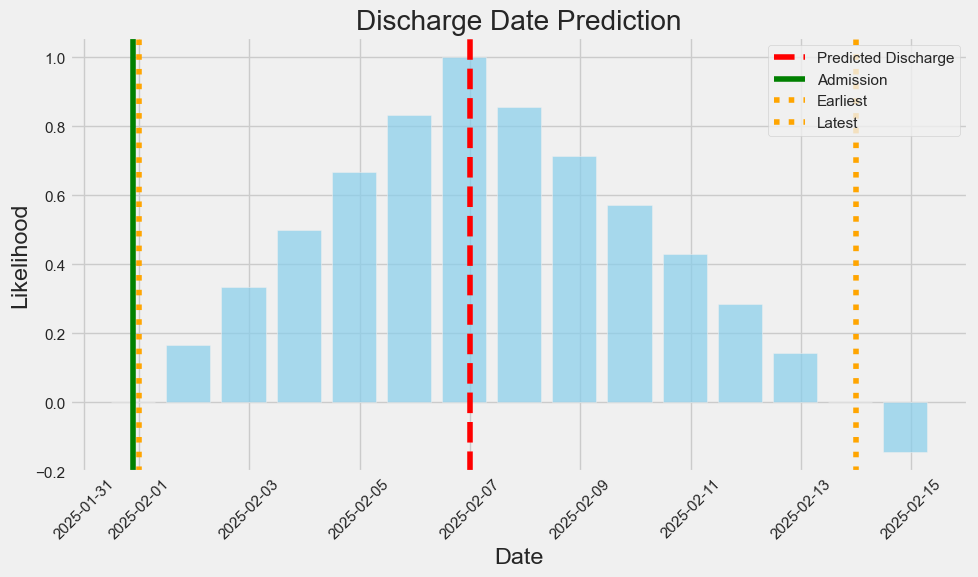

In [13]:
# ## 9. Feature Bridge for Using Limited JSON Input with Full Model (Fixed for Pickling)

# Update database connection parameters
DB_HOST = "localhost"
DB_PORT = "5432"
DB_NAME = "ward_data"
DB_USER = "kshitizbhatnagar"
DB_PASSWORD = ""  # Empty string for no password

import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import pickle
import json
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import lightgbm as lgb
from sqlalchemy import create_engine

def get_db_connection():
    """Create a connection to the PostgreSQL database with proper handling for no password"""
    try:
        # Construct connection string differently based on whether password is provided
        if DB_PASSWORD:
            connection_string = f"postgresql://{DB_USER}:{DB_PASSWORD}@{DB_HOST}:{DB_PORT}/{DB_NAME}"
        else:
            connection_string = f"postgresql://{DB_USER}@{DB_HOST}:{DB_PORT}/{DB_NAME}"
            
        engine = create_engine(connection_string)
        print("Successfully connected to PostgreSQL database!")
        return engine
    except Exception as e:
        print(f"Error connecting to database: {e}")
        return None

# Sample JSON fields - the limited input we have for prediction
sample_patient_json = {
  "mrn": "12345",
  "visit_date": "2025-01-31 21:25:00",
  "primary_diagnosis": "Pneumonia",
  "age": 65,
  "gender": "M",
  "comorbidities": ""
}

# Define the FeatureBridgePredictor class in the global scope so it can be pickled
class FeatureBridgePredictor:
    """
    Predictor that bridges between limited JSON input and full feature set
    """
    def __init__(self):
        self.full_model = None
        self.feature_stats = {}
        self.diagnosis_stats = {}
        self.features_by_diagnosis = {}
        self.input_columns = list(sample_patient_json.keys())
        self.expected_columns = []
        
    def fit(self, df):
        """Train the model and compute feature statistics"""
        # Compute statistics for each numeric feature grouped by diagnosis
        # This will help us predict missing features based on diagnosis
        features_by_diagnosis = {}
        
        if 'primary_diagnosis' in df.columns:
            # Get a list of all numeric columns
            numeric_cols = df.select_dtypes(include=np.number).columns.tolist()
            
            # Exclude certain columns from feature estimation
            exclude_cols = ['mrn', 'visit_id', 'actual_los']
            numeric_cols = [col for col in numeric_cols if col not in exclude_cols]
            
            # Compute statistics for each feature by diagnosis
            diagnoses = df['primary_diagnosis'].unique()
            for diagnosis in diagnoses:
                diagnosis_df = df[df['primary_diagnosis'] == diagnosis]
                features_by_diagnosis[diagnosis] = {}
                
                for col in numeric_cols:
                    if col in diagnosis_df.columns:
                        features_by_diagnosis[diagnosis][col] = {
                            'mean': diagnosis_df[col].mean(),
                            'median': diagnosis_df[col].median(),
                            'std': diagnosis_df[col].std()
                        }
        
        # Also compute general statistics for each feature
        feature_stats = {}
        numeric_cols = df.select_dtypes(include=np.number).columns.tolist()
        for col in numeric_cols:
            if col in df.columns:
                feature_stats[col] = {
                    'mean': df[col].mean(),
                    'median': df[col].median(),
                    'std': df[col].std()
                }
        
        # Compute diagnosis-specific statistics
        diagnosis_stats = {}
        if 'primary_diagnosis' in df.columns:
            diagnosis_groups = df.groupby('primary_diagnosis')['actual_los']
            diagnosis_stats = {
                'avg_los': diagnosis_groups.mean().to_dict(),
                'median_los': diagnosis_groups.median().to_dict(),
                'std_los': diagnosis_groups.std().fillna(2.0).to_dict(),
                'count': diagnosis_groups.count().to_dict()
            }
        
        # Store the statistics
        self.feature_stats = feature_stats
        self.features_by_diagnosis = features_by_diagnosis
        self.diagnosis_stats = diagnosis_stats
        
        # Train a model on the full data
        # Define features and target
        X = df.drop(columns=['actual_los', 'mrn'] if 'mrn' in df.columns else ['actual_los'])
        y = df['actual_los']
        
        # Split the data
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        
        # Identify categorical and numerical columns
        categorical_features = [col for col in X.columns if X[col].dtype == 'object']
        numerical_features = [col for col in X.columns if col not in categorical_features]
        
        print(f"Training with {len(numerical_features)} numerical features and {len(categorical_features)} categorical features")
        
        # Create preprocessing pipeline
        preprocessor = ColumnTransformer(
            transformers=[
                ('num', Pipeline([
                    ('imputer', SimpleImputer(strategy='median')),
                    ('scaler', StandardScaler())
                ]), numerical_features),
                ('cat', Pipeline([
                    ('imputer', SimpleImputer(strategy='most_frequent')),
                    ('onehot', OneHotEncoder(handle_unknown='ignore'))
                ]), categorical_features)
            ],
            remainder='drop'
        )
        
        # Define models to evaluate
        models = {
            'Linear Regression': LinearRegression(),
            'Ridge': Ridge(),
            'Lasso': Lasso(),
            'ElasticNet': ElasticNet(),
            'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
            'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
            'XGBoost': xgb.XGBRegressor(n_estimators=100, random_state=42),
            'LightGBM': lgb.LGBMRegressor(n_estimators=100, random_state=42),
            'SVR': SVR(kernel='rbf'),
            'KNN': KNeighborsRegressor(n_neighbors=5)
        }
        
        # Dictionary to store model results
        results = {}
        trained_models = {}
        
        # Train and evaluate each model
        for name, model in models.items():
            print(f"Training {name}...")
            
            # Create pipeline
            pipeline = Pipeline([
                ('preprocessor', preprocessor),
                ('model', model)
            ])
            
            # Train the model
            pipeline.fit(X_train, y_train)
            trained_models[name] = pipeline
            
            # Make predictions on test set
            y_pred = pipeline.predict(X_test)
            
            # Calculate performance metrics
            mae = mean_absolute_error(y_test, y_pred)
            rmse = np.sqrt(mean_squared_error(y_test, y_pred))
            r2 = r2_score(y_test, y_pred)
            
            # Store results
            results[name] = {
                'MAE': mae,
                'RMSE': rmse,
                'R2': r2
            }
            
            print(f"{name} - MAE: {mae:.2f}, RMSE: {rmse:.2f}, R2: {r2:.4f}")
        
        # Find the best model
        sorted_models = sorted(results.items(), key=lambda x: x[1]['MAE'])
        best_model_name, best_metrics = sorted_models[0]
        
        print("\nModels ranked by MAE:")
        for i, (name, metrics) in enumerate(sorted_models, 1):
            print(f"{i}. {name} - MAE: {metrics['MAE']:.2f}, RMSE: {metrics['RMSE']:.2f}, R2: {metrics['R2']:.4f}")
        
        print(f"\n=== SELECTED MODEL: {best_model_name} ===")
        print(f"Best model metrics - MAE: {best_metrics['MAE']:.2f}, RMSE: {best_metrics['RMSE']:.2f}, R2: {best_metrics['R2']:.4f}")
        
        # Store the best model
        self.full_model = trained_models[best_model_name]
        self.model_type = best_model_name
        
        # Store the expected column list
        self.expected_columns = X.columns.tolist()
        
        return self
    
    def predict_from_json(self, patient_json):
        """
        Predict LOS using only the fields in the JSON input
        by building a bridge to the full feature set
        """
        # Check if model exists
        if self.full_model is None:
            raise ValueError("Model has not been trained. Call fit() before making predictions.")
            
        # Convert JSON to DataFrame
        patient_data = pd.DataFrame([patient_json])
        
        # Extract basic information
        visit_date = pd.to_datetime(patient_json.get('visit_date'))
        diagnosis = patient_json.get('primary_diagnosis', '')
        age = patient_json.get('age', 50)  # Default age if not provided
        gender = patient_json.get('gender', 'M')  # Default gender if not provided
        comorbidities = patient_json.get('comorbidities', '')
        
        # Get diagnosis-specific feature values or fallback to overall medians
        # This is the key part of our feature bridge
        full_features = {}
        
        # Start with features we directly have
        full_features['age'] = age
        full_features['gender'] = gender
        
        # Add date-related features
        full_features['visit_year'] = visit_date.year
        full_features['visit_month'] = visit_date.month
        full_features['visit_day'] = visit_date.day
        full_features['visit_hour'] = visit_date.hour
        full_features['visit_weekday'] = visit_date.weekday()
        full_features['visit_is_weekend'] = 1 if visit_date.weekday() >= 5 else 0
        
        # Add comorbidity features
        full_features['comorbidities'] = comorbidities
        full_features['num_comorbidities'] = len(comorbidities.split(',')) if comorbidities and comorbidities != 'None' else 0
        
        # Add diagnosis
        full_features['primary_diagnosis'] = diagnosis
        
        # Add estimated values for all other numeric features based on diagnosis
        if diagnosis in self.features_by_diagnosis:
            diagnosis_features = self.features_by_diagnosis[diagnosis]
            
            for feature, stats in diagnosis_features.items():
                if feature not in full_features:
                    # Use median as it's more robust
                    full_features[feature] = stats['median']
        else:
            # If diagnosis not found, use overall feature statistics
            for feature, stats in self.feature_stats.items():
                if feature not in full_features:
                    full_features[feature] = stats['median']
        
        # Create a DataFrame with all expected columns
        bridged_df = pd.DataFrame([full_features])
        
        # Make sure all expected columns are present
        for col in self.expected_columns:
            if col not in bridged_df.columns:
                # Add with a default value
                if col in self.feature_stats:
                    bridged_df[col] = self.feature_stats[col]['median']
                else:
                    # For categorical features, use empty string
                    bridged_df[col] = ''
        
        # The prediction now uses the pipeline that includes preprocessing
        # so we don't need to preprocess the data here
        los_prediction = self.full_model.predict(bridged_df)[0]
        los_prediction_rounded = round(los_prediction)
        
        # Calculate estimated discharge date
        discharge_date = visit_date + pd.Timedelta(days=los_prediction_rounded)
        
        # Calculate confidence interval
        std_dev = self.diagnosis_stats['std_los'].get(diagnosis, 2.0) if diagnosis in self.diagnosis_stats.get('std_los', {}) else 2.0
        
        lower_bound = max(1, round(los_prediction - 1.96 * std_dev))
        upper_bound = round(los_prediction + 1.96 * std_dev)
        
        # Create result dictionary
        prediction = {
            'predicted_los': los_prediction_rounded,
            'estimated_discharge_date': discharge_date.strftime('%Y-%m-%d'),
            'earliest_discharge': (visit_date + pd.Timedelta(days=lower_bound)).strftime('%Y-%m-%d'),
            'latest_discharge': (visit_date + pd.Timedelta(days=upper_bound)).strftime('%Y-%m-%d')
        }
        
        return prediction

# Function to build a feature bridge and test it
def build_feature_bridge_and_test(model_path=None):
    """
    Build a feature bridge that maps limited JSON input to full model features,
    train a model, and test it with the sample data.
    
    Parameters:
    -----------
    model_path : str
        Path to save/load the model
    """
    # Get database connection
    engine = get_db_connection()
    if engine is None:
        print("Failed to connect to database. Exiting.")
        return None, None
    
    try:
        # Load data from database
        query = "SELECT * FROM hospital_data"
        df = pd.read_sql_query(query, engine)
        print(f"Loaded {len(df)} records from database")
        
        # Process datetime columns consistently
        datetime_cols = ['visit_date', 'actual_discharge_date', 'expected_discharge_date']
        for col in datetime_cols:
            if col in df.columns:
                df[col] = pd.to_datetime(df[col], errors='coerce')
        
        # Create date features from visit_date
        if 'visit_date' in df.columns:
            df['visit_year'] = df['visit_date'].dt.year
            df['visit_month'] = df['visit_date'].dt.month
            df['visit_day'] = df['visit_date'].dt.day
            df['visit_hour'] = df['visit_date'].dt.hour
            df['visit_weekday'] = df['visit_date'].dt.weekday
            df['visit_is_weekend'] = df['visit_weekday'].apply(lambda x: 1 if x >= 5 else 0)
            df = df.drop(columns=['visit_date'])
        
        # Drop other datetime columns that aren't needed for prediction
        if 'actual_discharge_date' in df.columns:
            df = df.drop(columns=['actual_discharge_date'])
        if 'expected_discharge_date' in df.columns:
            df = df.drop(columns=['expected_discharge_date'])
        
        # Make sure the target variable exists
        if 'actual_los' not in df.columns:
            print("Error: 'actual_los' (target variable) is missing in the database!")
            return None, None
        
        # Clean target variable and ensure we have enough data
        df = df.dropna(subset=['actual_los'])
        df['actual_los'] = pd.to_numeric(df['actual_los'], errors='coerce')
        
        if len(df) < 10:
            print(f"Error: Not enough valid records. Only {len(df)} records remain.")
            return None, None
        
        print(f"Training with {len(df)} valid records")
        
        # Create and train the feature bridge predictor
        predictor = FeatureBridgePredictor()
        predictor.fit(df)
        
        # Save the model if path provided
        if model_path:
            with open(model_path, 'wb') as f:
                pickle.dump(predictor, f)
            print(f"Model saved to {model_path}")
        
        # Test with the sample patient data
        print("\nTesting with sample patient data:")
        print(json.dumps(sample_patient_json, indent=2))
        
        prediction = predictor.predict_from_json(sample_patient_json)
        
        # Print results
        print("\nPrediction Results:")
        print(f"Predicted Length of Stay: {prediction['predicted_los']} days")
        print(f"Estimated Discharge Date: {prediction['estimated_discharge_date']}")
        print(f"Earliest Possible Discharge: {prediction['earliest_discharge']}")
        print(f"Latest Possible Discharge: {prediction['latest_discharge']}")
        
        return predictor, prediction
    
    except Exception as e:
        print(f"Error: {str(e)}")
        import traceback
        traceback.print_exc()
        return None, None

# Run the function
predictor, prediction = build_feature_bridge_and_test('feature_bridge_model.pkl')

# Create a simple visualization if prediction is available
if prediction:
    try:
        import matplotlib.pyplot as plt
        
        # Parse dates
        visit_date = pd.to_datetime(sample_patient_json['visit_date'])
        discharge_date = pd.to_datetime(prediction['estimated_discharge_date'])
        earliest_date = pd.to_datetime(prediction['earliest_discharge'])
        latest_date = pd.to_datetime(prediction['latest_discharge'])
        
        # Create date range for plotting
        date_range = pd.date_range(visit_date, latest_date + pd.Timedelta(days=1))
        
        # Create bar heights (simple triangular distribution)
        heights = []
        for date in date_range:
            days_from_admission = (date - visit_date).days
            target_day = (discharge_date - visit_date).days
            
            # Higher near predicted date, lower as we move away
            if days_from_admission <= target_day:
                height = days_from_admission / max(1, target_day)
            else:
                days_remaining = (latest_date - date).days
                total_days_after = (latest_date - discharge_date).days
                height = days_remaining / max(1, total_days_after) if total_days_after > 0 else 0
            
            heights.append(height)
        
        # Create the visualization
        plt.figure(figsize=(10, 6))
        plt.bar(date_range, heights, width=0.8, alpha=0.7, color='skyblue')
        plt.axvline(x=discharge_date, color='red', linestyle='--', label='Predicted Discharge')
        plt.axvline(x=visit_date, color='green', linestyle='-', label='Admission')
        plt.axvline(x=earliest_date, color='orange', linestyle=':', label='Earliest')
        plt.axvline(x=latest_date, color='orange', linestyle=':', label='Latest')
        
        plt.xlabel('Date')
        plt.ylabel('Likelihood')
        plt.title('Discharge Date Prediction')
        plt.xticks(rotation=45)
        plt.legend()
        plt.tight_layout()
        plt.show()
        
    except Exception as viz_error:
        print(f"Could not create visualization: {str(viz_error)}")

# Function to load and use the saved model for prediction
def predict_with_saved_model(model_path, patient_json):
    """
    Load the saved model and make a prediction for a new patient
    
    Parameters:
    -----------
    model_path : str
        Path to the saved model
    patient_json : dict
        Patient data in JSON format
        
    Returns:
    --------
    prediction : dict
        Prediction results
    """
    try:
        # Load the model
        with open(model_path, 'rb') as f:
            predictor = pickle.load(f)
            
        # Make prediction
        prediction = predictor.predict_from_json(patient_json)
        
        return prediction
    
    except Exception as e:
        print(f"Error loading model or making prediction: {str(e)}")
        return None

In [16]:
# Add this code to a new cell in your notebook

# First, import the class from the external file
import sys
sys.path.append('.')  # Make sure the current directory is in the path
from model_classes import FeatureBridgePredictor

# Import necessary ML libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.impute import SimpleImputer
import pandas as pd
import numpy as np

# This assumes you have already loaded your data into a DataFrame called 'df'
# Make sure 'df' contains your hospital data and has an 'actual_los' column

# Create new predictor instance using the imported class
predictor = FeatureBridgePredictor()

# First, let's modify the fit method to explicitly create and train the model
def custom_fit(predictor, df):
    """Custom fit method that ensures the model is created and trained"""
    # Check and handle datetime columns
    df_copy = df.copy()
    datetime_cols = df_copy.select_dtypes(include=['datetime64']).columns
    
    print(f"Found datetime columns: {list(datetime_cols)}")
    
    # Convert datetime columns to numeric features
    for col in datetime_cols:
        print(f"Converting datetime column: {col}")
        # Extract components and drop original
        if col in df_copy.columns:
            # Extract year, month, day, etc.
            df_copy[f"{col}_year"] = df_copy[col].dt.year
            df_copy[f"{col}_month"] = df_copy[col].dt.month
            df_copy[f"{col}_day"] = df_copy[col].dt.day
            df_copy[f"{col}_dayofweek"] = df_copy[col].dt.dayofweek
            
            # Drop the original datetime column
            df_copy = df_copy.drop(columns=[col])
    
    # Call the original fit method to compute statistics
    predictor.fit(df_copy)
    
    print("Creating and training a model with proper preprocessing...")
    
    # Define features and target
    X = df_copy.drop(columns=['actual_los', 'mrn'] if 'mrn' in df_copy.columns else ['actual_los'])
    y = df_copy['actual_los']
    
    # Identify categorical and numerical columns
    categorical_cols = [col for col in X.columns if X[col].dtype == 'object']
    numerical_cols = [col for col in X.columns if X[col].dtype != 'object']
    
    print(f"Categorical columns: {categorical_cols}")
    print(f"Numerical columns (first 10): {numerical_cols[:10]}...")
    print(f"Total columns: {len(categorical_cols) + len(numerical_cols)}")
    
    # Create preprocessing pipeline with separate transformers for numerical and categorical data
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', Pipeline([
                ('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler())
            ]), numerical_cols),
            ('cat', Pipeline([
                ('imputer', SimpleImputer(strategy='most_frequent')),
                ('onehot', OneHotEncoder(handle_unknown='ignore'))
            ]), categorical_cols)
        ]
    )
    
    # Create the full pipeline with preprocessor and model
    full_pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', GradientBoostingRegressor(
            n_estimators=100,
            learning_rate=0.1,
            max_depth=5,
            random_state=42
        ))
    ])
    
    # Split data (optional, but good practice)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Train the model
    print("Training the model...")
    full_pipeline.fit(X_train, y_train)
    
    # Set the model in the predictor
    predictor.full_model = full_pipeline
    predictor.model_type = "GradientBoostingWithPreprocessing"
    
    # Update expected columns if needed
    predictor.expected_columns = X.columns.tolist()
    
    # Evaluate the model
    from sklearn.metrics import mean_absolute_error
    y_pred = full_pipeline.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    print(f"Model trained! Test MAE: {mae:.2f} days")
    
    return predictor

# Fit the model with our custom function
predictor = custom_fit(predictor, df)

# Save the model to a new pickle file
import pickle
with open("feature_bridge_model_new.pkl", "wb") as f:
    pickle.dump(predictor, f)

print("Model trained and saved to feature_bridge_model_new.pkl")

# Test the model with sample data to ensure it works
sample_patient = {
    "mrn": "12345",
    "visit_date": "2025-01-31 21:25:00",
    "primary_diagnosis": "Pneumonia",
    "age": 65,
    "gender": "M",
    "comorbidities": "Diabetes,Hypertension"
}

# Update predict_from_json to handle datetime conversion
def modified_predict(predictor, patient_json):
    """Modified prediction function that handles datetime conversion"""
    # Check if model exists
    if predictor.full_model is None:
        raise ValueError("Model has not been trained. Call fit() before making predictions.")
        
    # Convert JSON to DataFrame
    patient_data = pd.DataFrame([patient_json])
    
    # Extract basic information
    visit_date = pd.to_datetime(patient_json.get('visit_date'))
    diagnosis = patient_json.get('primary_diagnosis', '')
    age = patient_json.get('age', 50)  # Default age if not provided
    gender = patient_json.get('gender', 'M')  # Default gender if not provided
    comorbidities = patient_json.get('comorbidities', '')
    
    # Get diagnosis-specific feature values or fallback to overall medians
    # This is the key part of our feature bridge
    full_features = {}
    
    # Start with features we directly have
    full_features['age'] = age
    full_features['gender'] = gender
    
    # Add date-related features - make sure these match how we processed in training
    # We need to extract the same features as we did in training
    full_features['visit_date_year'] = visit_date.year
    full_features['visit_date_month'] = visit_date.month
    full_features['visit_date_day'] = visit_date.day
    full_features['visit_date_dayofweek'] = visit_date.dayofweek
    
    # Add comorbidity features
    full_features['comorbidities'] = comorbidities
    full_features['num_comorbidities'] = len(comorbidities.split(',')) if comorbidities and comorbidities != 'None' else 0
    
    # Add diagnosis
    full_features['primary_diagnosis'] = diagnosis
    
    # Add estimated values for all other numeric features based on diagnosis
    if diagnosis in predictor.features_by_diagnosis:
        diagnosis_features = predictor.features_by_diagnosis[diagnosis]
        
        for feature, stats in diagnosis_features.items():
            if feature not in full_features:
                # Use median as it's more robust
                full_features[feature] = stats['median']
    else:
        # If diagnosis not found, use overall feature statistics
        for feature, stats in predictor.feature_stats.items():
            if feature not in full_features:
                full_features[feature] = stats['median']
    
    # Create a DataFrame with all expected columns
    bridged_df = pd.DataFrame([full_features])
    
    # Make sure all expected columns are present
    for col in predictor.expected_columns:
        if col not in bridged_df.columns:
            # Add with a default value
            if col in predictor.feature_stats:
                bridged_df[col] = predictor.feature_stats[col]['median']
            else:
                # For categorical features, use empty string
                bridged_df[col] = ''
    
    # The prediction now uses the pipeline that includes preprocessing
    # so we don't need to preprocess the data here
    los_prediction = predictor.full_model.predict(bridged_df)[0]
    los_prediction_rounded = round(los_prediction)
    
    # Calculate estimated discharge date
    discharge_date = visit_date + pd.Timedelta(days=los_prediction_rounded)
    
    # Calculate confidence interval
    std_dev = predictor.diagnosis_stats['std_los'].get(diagnosis, 2.0) if diagnosis in predictor.diagnosis_stats.get('std_los', {}) else 2.0
    
    lower_bound = max(1, round(los_prediction - 1.96 * std_dev))
    upper_bound = round(los_prediction + 1.96 * std_dev)
    
    # Create result dictionary
    prediction = {
        'predicted_los': los_prediction_rounded,
        'estimated_discharge_date': discharge_date.strftime('%Y-%m-%d'),
        'earliest_discharge': (visit_date + pd.Timedelta(days=lower_bound)).strftime('%Y-%m-%d'),
        'latest_discharge': (visit_date + pd.Timedelta(days=upper_bound)).strftime('%Y-%m-%d')
    }
    
    return prediction

# Test with sample data
try:
    # Use our modified predict function to test
    result = modified_predict(predictor, sample_patient)
    print("\nSample prediction result:")
    print(f"Predicted Length of Stay: {result['predicted_los']} days")
    print(f"Estimated Discharge Date: {result['estimated_discharge_date']}")
    print(f"Earliest Possible Discharge: {result['earliest_discharge']}")
    print(f"Latest Possible Discharge: {result['latest_discharge']}")
    
    # Now update the predictor's prediction method to match our modified version
    predictor.predict_from_json = lambda patient_json: modified_predict(predictor, patient_json)
    
    # Save the updated predictor
    with open("feature_bridge_model_new.pkl", "wb") as f:
        pickle.dump(predictor, f)
    
    print("\nUpdated model saved with modified prediction function")
except Exception as e:
    print(f"\nError during prediction: {str(e)}")
    import traceback
    traceback.print_exc()

SyntaxError: invalid syntax. Perhaps you forgot a comma? (3513844695.py, line 337)